# Beacon

## Implementación algoritmo base

In [1]:
import random
import time
from collections import defaultdict
from typing import List, Tuple, Dict, Set

In [2]:
def gen_vec_strings(n: int, k: int) -> List[int]:
    if n > 64:
        raise ValueError("Only supports up to 64-bit integers.")
    return [random.getrandbits(n) for _ in range(k)]


def hamming_distance(x: int, y: int) -> int:
    return bin(x ^ y).count("1")


def create_edges(nodes: List[int], threshold: int) -> List[Tuple[int, int]]:
    edges = []
    k = len(nodes)
    for i in range(k):
        for j in range(i + 1, k):
            if hamming_distance(nodes[i], nodes[j]) <= threshold:
                edges.append((i, j))
    return edges


def gen_connectivity(k: int, edges: List[Tuple[int, int]]):
    d_count = {i: 0 for i in range(k)}
    d_connect = {i: set() for i in range(k)}
    d_degree_set = defaultdict(set)

    for i, j in edges:
        d_connect[i].add(j)
        d_connect[j].add(i)
        d_count[i] += 1
        d_count[j] += 1

    max_degree = 0
    for i in range(k):
        deg = d_count[i]
        max_degree = max(max_degree, deg)
        d_degree_set[deg].add(i)

    for d in range(max_degree):
        d_degree_set.setdefault(d, set())

    return max_degree, d_count, d_connect, d_degree_set


def filter_greedy(maxdeg: int, d_count, d_connect, d_degree_set) -> List[int]:
    import copy
    d_count = copy.deepcopy(d_count)
    d_connect = copy.deepcopy(d_connect)
    d_degree_set = copy.deepcopy(d_degree_set)

    if maxdeg < 1:
        return list(d_degree_set[0])

    for deg in range(maxdeg, 0, -1):
        while d_degree_set[deg]:
            i = d_degree_set[deg].pop()
            for j in list(d_connect[i]):
                d_connect[j].remove(i)
                old_deg = d_count[j]
                d_degree_set[old_deg].discard(j)
                d_count[j] -= 1
                d_degree_set[d_count[j]].add(j)

    assert all(len(s) == 0 for d, s in d_degree_set.items() if d > 0)
    return list(d_degree_set[0])


def filter_linear(k: int, d_connect) -> List[int]:
    available = [True] * k
    selected = []
    for i in range(k):
        if available[i]:
            selected.append(i)
            for j in d_connect[i]:
                available[j] = False
    return selected


def benchmark_hw_dist_filters(n: int, k: int, thresh: int) -> Tuple[int, int, float]:
    print(f"\nRunning benchmark with n={n}, k={k}, t={thresh}")
    t0 = time.time()

    print("Generating random strings...")
    nodes = gen_vec_strings(n, k)

    print("Creating edges...")
    edges = create_edges(nodes, thresh)

    print("Generating connectivity...")
    maxdeg, d_count, d_connect, d_degree_set = gen_connectivity(k, edges)

    print("Applying linear filter...")
    L1 = filter_linear(k, d_connect)

    print("Applying greedy filter...")
    L2 = filter_greedy(maxdeg, d_count, d_connect, d_degree_set)

    t1 = time.time()
    duration = round(t1 - t0, 4)

    print(f"Linear filter kept {len(L1)} strings ({round(len(L1) / k * 100, 2)}%)")
    print(f"Greedy filter kept {len(L2)} strings ({round(len(L2) / k * 100, 2)}%)")
    print(f"Total time: {duration} seconds")

    return len(L1), len(L2), duration


In [3]:
if __name__ == "__main__":
    n, k, t = 53, 10_000, 10
    l1, l2, duration = benchmark_hw_dist_filters(n, k, t)
    print("l1:", l1)
    print("l2:", l2)
    print("Duration:", duration)
    print("Benchmark completed.")



Running benchmark with n=53, k=10000, t=10
Generating random strings...
Creating edges...
Generating connectivity...
Applying linear filter...
Applying greedy filter...
Linear filter kept 9853 strings (98.53%)
Greedy filter kept 9854 strings (98.54%)
Total time: 17.2459 seconds
l1: 9853
l2: 9854
Duration: 17.2459
Benchmark completed.


## Método de generación de distribución

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from collections import Counter

def graficar_histograma_bytes(values, filename="random_bits_histogram.png", aditional_title=""):
    # Paso 1: Calcular frecuencias
    byte_counts = Counter(values)
    most_freq_byte = max(byte_counts, key=byte_counts.get)
    least_freq_byte = min(byte_counts, key=byte_counts.get)
    most_freq_density = byte_counts[most_freq_byte] / len(values)
    least_freq_density = byte_counts[least_freq_byte] / len(values)

    # Paso 2: Crear histograma
    plt.figure(figsize=(10, 6))
    count, bins, _ = plt.hist(values, bins=256, density=True, alpha=0.6, color='skyblue', label='Frequency')

    # Paso 3: Superponer distribución normal
    mu, sigma = np.mean(values), np.std(values)
    x = np.linspace(0, 255, 256)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f'Normal Distribution\nμ={mu:.2f}, σ={sigma:.2f}')

    # Paso 4: Resaltar el más y menos frecuente
    plt.axvline(most_freq_byte, color='green', linestyle='--', linewidth=1.5, label=f'Most Frequent: {most_freq_byte}')
    plt.text(most_freq_byte + 1, most_freq_density,
             f'{most_freq_byte}\nCount: {byte_counts[most_freq_byte]}',
             color='green', fontsize=9, ha='left', va='bottom')

    plt.axvline(least_freq_byte, color='purple', linestyle='--', linewidth=1.5, label=f'Least Frequent: {least_freq_byte}')
    plt.text(least_freq_byte + 1, least_freq_density,
             f'{least_freq_byte}\nCount: {byte_counts[least_freq_byte]}',
             color='purple', fontsize=9, ha='left', va='bottom')

    # Paso 5: Configuración final
    total_bytes = len(values)
    plt.title(f'Histogram of {total_bytes:,} Random Bytes\nwith Normal Distribution Overlay\n{aditional_title}')
    plt.xlabel('Byte Value (0–255)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Paso 6: Guardar y mostrar
    plt.savefig(filename, dpi=300)
    plt.show()

In [5]:
def bits_a_bytes(bit_string):
    # Asegurar que la longitud sea múltiplo de 8
    if len(bit_string) % 8 != 0:
        raise ValueError("La cadena de bits debe tener una longitud múltiplo de 8.")
    
    # Convertir cada grupo de 8 bits a entero
    return [int(bit_string[i:i+8], 2) for i in range(0, len(bit_string), 8)]

[108, 101, 47]


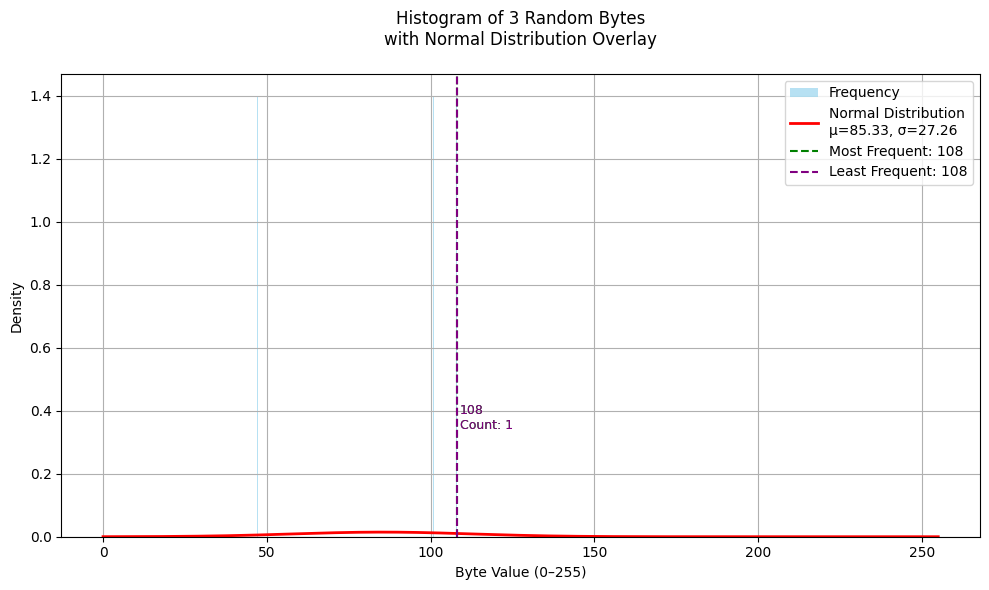

In [6]:
## Ejemplo de uso
bit_string = "011011000110010100101111"
bytes_list = bits_a_bytes(bit_string)
print(bytes_list)  # Ejemplo de salida: [108, 101, 47]

graficar_histograma_bytes(bytes_list, "histograma.png")

## Captura últimos 15635 pulson del beacon de la Nist

Equivalente a 1 000 000 de bits

In [7]:
import requests

def obtener_outputvalue_bytes(pulse_url):
    # Consultar la API
    response = requests.get(pulse_url)
    response.raise_for_status()
    
    data = response.json()
    hex_string = data['pulse']['outputValue']
    
    # Convertir de hexadecimal a bytes
    byte_data = bytes.fromhex(hex_string)
    
    # Convertir bytes a lista de enteros
    byte_list = list(byte_data)
    
    return byte_list

/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [8]:
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm

def obtener_outputvalue_bytes(pulse_url):
    try:
        response = requests.get(pulse_url, timeout=10)
        response.raise_for_status()
        data = response.json()
        hex_string = data['pulse']['outputValue']
        byte_data = bytes.fromhex(hex_string)
        return list(byte_data)
    except Exception as e:
        print(f"Error en {pulse_url}: {e}")
        return None

def descargar_valores_en_paralelo(index_pulse, cantidad=15625, max_workers=20):
    random_bytes = []
    urls = [
        f"https://beacon.nist.gov/beacon/2.0/chain/2/pulse/{index_pulse - i}"
        for i in range(cantidad)
    ]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(obtener_outputvalue_bytes, url): url for url in urls}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Descargando en paralelo"):
            result = future.result()
            if result is not None:
                random_bytes.append(result)

    return random_bytes

In [9]:
# Uso
index_pulse = 1338590
random_bytes = descargar_valores_en_paralelo(index_pulse)

Descargando en paralelo:   0%|          | 0/15625 [00:00<?, ?it/s]

Error en https://beacon.nist.gov/beacon/2.0/chain/2/pulse/1338113: HTTPSConnectionPool(host='beacon.nist.gov', port=443): Read timed out. (read timeout=10)
Error en https://beacon.nist.gov/beacon/2.0/chain/2/pulse/1338069: 502 Server Error: Bad Gateway for url: https://beacon.nist.gov/beacon/2.0/chain/2/pulse/1338069
Error en https://beacon.nist.gov/beacon/2.0/chain/2/pulse/1337096: HTTPSConnectionPool(host='beacon.nist.gov', port=443): Read timed out. (read timeout=10)
Error en https://beacon.nist.gov/beacon/2.0/chain/2/pulse/1336960: HTTPSConnectionPool(host='beacon.nist.gov', port=443): Read timed out. (read timeout=10)
Error en https://beacon.nist.gov/beacon/2.0/chain/2/pulse/1332943: HTTPSConnectionPool(host='beacon.nist.gov', port=443): Read timed out. (read timeout=10)
Error en https://beacon.nist.gov/beacon/2.0/chain/2/pulse/1332465: HTTPSConnectionPool(host='beacon.nist.gov', port=443): Read timed out. (read timeout=10)
Error en https://beacon.nist.gov/beacon/2.0/chain/2/pulse

In [10]:
from itertools import chain

# Aplanar la lista anidada
nested_bytes = [list(map(int, byte)) for byte in random_bytes]
print("Total de bytes descargados:", len(nested_bytes))


Total de bytes descargados: 15397


In [11]:
# Aplanar a lista de bits
flattened_bits = [
    (byte >> i) & 1
    for sublist in random_bytes
    for byte in sublist
    for i in reversed(range(8))  # de bit más significativo a menos significativo
]

print(flattened_bits[:100])

[0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


In [12]:
with open("beaconSeedsFromIndex_1322965_To_1338590.txt", "a", encoding="utf-8") as archivo:
    archivo.write(''.join(map(str, flattened_bits)))

## Generación histograma

### Semilla desde la API oficial de la Nist de beacon

https://beacon.nist.gov/beacon/2.0/chain/2/pulse/<indexPulse>

Cara pulso genera un número de 512 bits, su representación de ejemplo en hexadecimal es:
5CD034027CA1BC416AEEA71BE04B066EBC46A5BC20033990814C4D36E7ACDD7FC76B639A541F28F40C3372B53A22ADA387031B6CEDA3E560E2E1903BE3B58991

1000110100


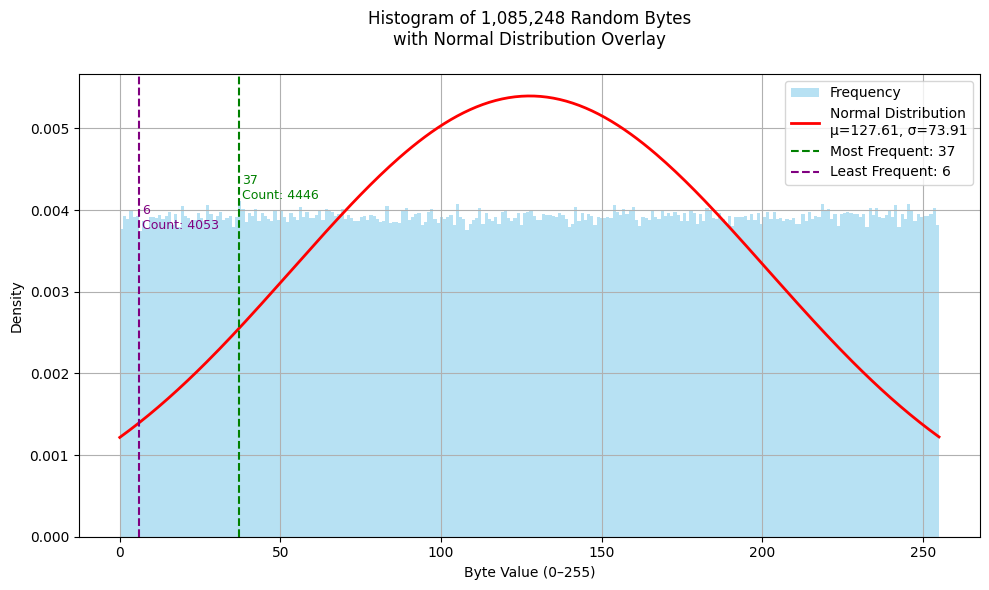

In [16]:
def leer_string_de_archivo(nombre_archivo):
    with open(nombre_archivo, 'r', encoding='utf-8') as archivo:
        contenido = archivo.read()
    return contenido
def bits_a_bytes(bit_string):
    # Asegurar que la longitud sea múltiplo de 8
    if len(bit_string) % 8 != 0:
        raise ValueError("La cadena de bits debe tener una longitud múltiplo de 8.")
    
    # Convertir cada grupo de 8 bits a entero
    return [int(bit_string[i:i+8], 2) for i in range(0, len(bit_string), 8)]

texto = leer_string_de_archivo("beaconSeedsFromIndex_1322965_To_1338590.txt")
print(texto[:10])  # Muestra los primeros 10 caracteres
bytes_list = bits_a_bytes(texto)
graficar_histograma_bytes(bytes_list, "beaconBitsFormApiIndexFrom1322965To1338590.png")

## Semilla API ofical Beecon distribución para 50 000 bytes

In [14]:
texto = leer_string_de_archivo("beaconSeedsFromIndex_1322965_To_1338590.txt")
print(texto[:10])  # Muestra los primeros 10 caracteres
len(texto)  # Muestra la longitud total de la cadena

1000110100


8681984

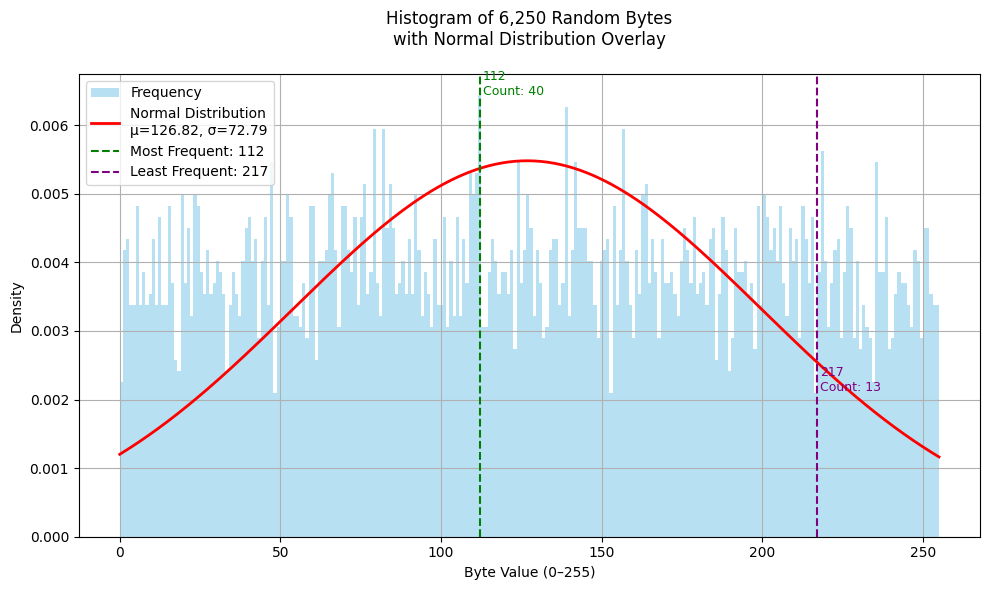

In [18]:
bytes_list = bits_a_bytes(texto[:50000])
graficar_histograma_bytes(bytes_list, "beaconBitsFormApi50_000Bytes.png")